# Task-4 Image Reconstruction using Matrix Factorisation

# Question 4.2

Q2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.

### Importing Required Libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

# remove all warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Number of GPUs:', torch.cuda.device_count())
# torch.cuda.set_device(0)

Using device: cpu
Number of GPUs: 0


In [18]:
# print(torch.cuda.is_available())  # Should return True if GPU is available
# print(torch.cuda.get_device_name(0))  # Print the name of the GPU


In [19]:
# Setting the seed for Python, NumPy, and PyTorch (both CPU and GPU)
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # if using CUDA
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disables the auto-tuner that finds the best algorithm

set_seed(42)

### Load the iamge

In [20]:
img = torchvision.io.read_image('/kaggle/input/iitgn-img/iitgn.jpg')
print(img.shape)

torch.Size([3, 640, 1280])


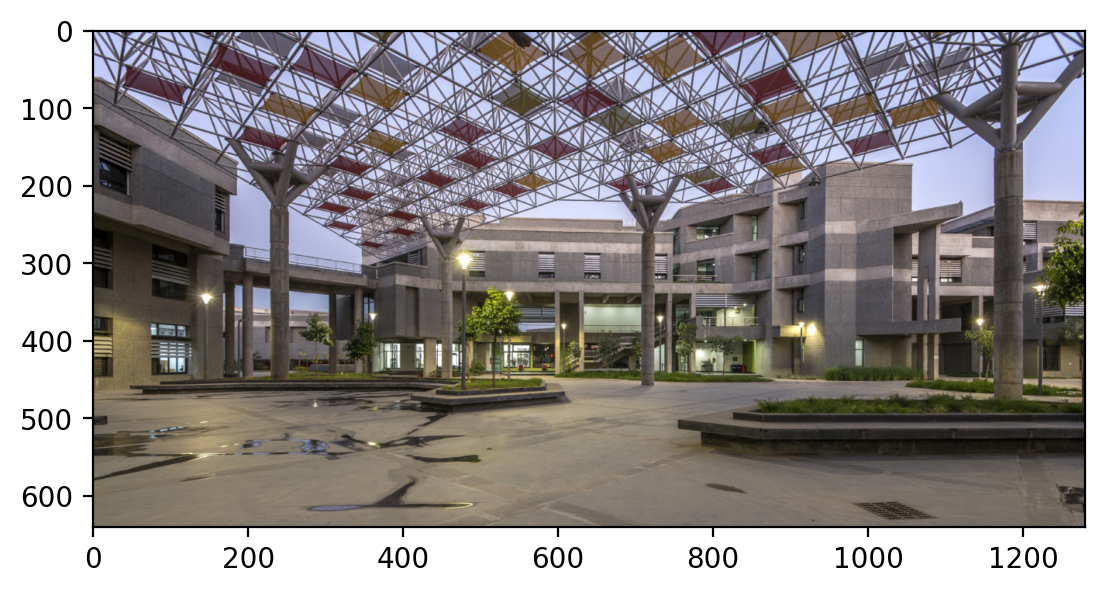

In [21]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

### Scale the image to [0,1]

In [22]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [23]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)

img_scaled = img_scaled.to(device)
print("Shape of the scaled image:", img_scaled.shape)
img_scaled

Shape of the scaled image: torch.Size([3, 640, 1280])


tensor([[[0.7922, 0.7490, 0.7804,  ..., 0.7451, 0.7647, 0.7569],
         [0.7725, 0.7647, 0.7765,  ..., 0.7490, 0.7529, 0.7451],
         [0.7137, 0.7373, 0.8039,  ..., 0.7412, 0.7490, 0.7451],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.4667, 0.4706, 0.4745],
         [0.4784, 0.4784, 0.4784,  ..., 0.4706, 0.4667, 0.4667],
         [0.4784, 0.4745, 0.4745,  ..., 0.4706, 0.4667, 0.4627]],

        [[0.8392, 0.7922, 0.8039,  ..., 0.8157, 0.8314, 0.8235],
         [0.8353, 0.8118, 0.8078,  ..., 0.8235, 0.8196, 0.8078],
         [0.7804, 0.7961, 0.8471,  ..., 0.8235, 0.8118, 0.7922],
         ...,
         [0.4431, 0.4431, 0.4431,  ..., 0.4314, 0.4353, 0.4392],
         [0.4431, 0.4431, 0.4431,  ..., 0.4353, 0.4314, 0.4314],
         [0.4431, 0.4392, 0.4392,  ..., 0.4353, 0.4314, 0.4275]],

        [[1.0000, 0.9686, 0.9373,  ..., 0.9569, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9608,  ..., 0.9882, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.

### Crop the image

torch.Size([3, 300, 300])


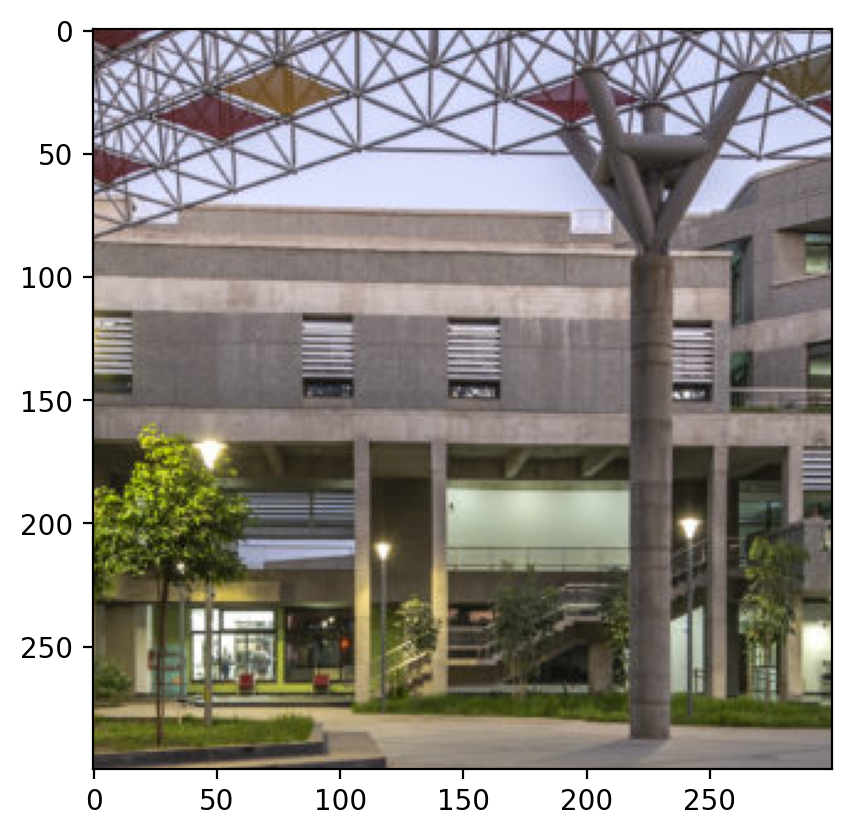

In [24]:
crop = torchvision.transforms.CenterCrop(300)(img_scaled)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)

### Masking a square patch on the image

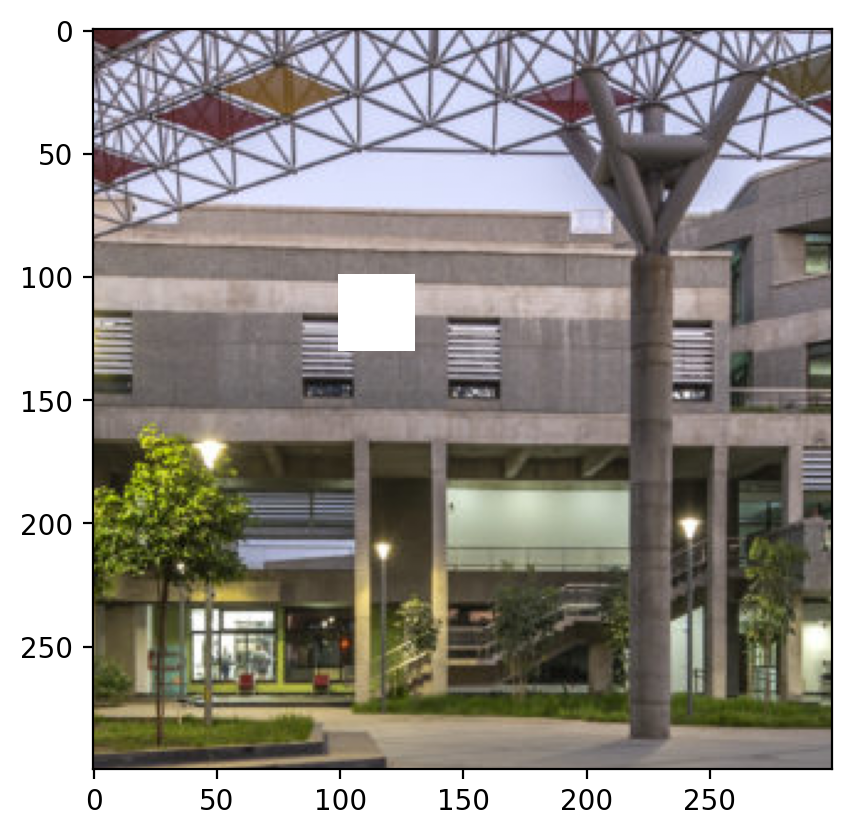

In [25]:
channels, height, width = crop.shape

patch_size = 30

if patch_size > height or patch_size > width:
    raise ValueError("Patch size must be smaller than the dimensions of the image.")

# # Randomly select the top-left corner of the patch
# margin = 30  # margin to avoid the corners
# top_left_x = np.random.randint(margin, height - patch_size - margin)
# top_left_y = np.random.randint(margin, width - patch_size - margin)

top_left_x = 100
top_left_y = 100

# Remove the patch from the image
masked_img = crop.clone()
masked_img[:, top_left_x:top_left_x + patch_size, top_left_y:top_left_y + patch_size] = float('nan')

plt.imshow(rearrange(masked_img, 'c h w -> h w c').cpu().numpy())


## Reconstruction using Random Fourier Features

In [26]:

def plot_results(original_img, masked_img, reconstructed_img, rank, mask_value):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Image Reconstruction with Rank={rank} and Mask={mask_value}x{mask_value} patch")
    # Original image
    axes[0].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    # Masked image
    axes[1].imshow(rearrange(masked_img, 'c h w -> h w c').cpu().numpy())
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    # Reconstructed image
    axes[2].imshow(rearrange(reconstructed_img, 'c h w -> h w c').cpu().detach().numpy())
    axes[2].set_title("Reconstructed Image")
    axes[2].axis('off')
    plt.show()


def calculate_rmse_psnr(original_img, reconstructed_img):
    """
    Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.
    
    Args:
        original_img (torch.Tensor): The original image tensor.
        reconstructed_img (torch.Tensor): The reconstructed image tensor.
    
    Returns:
        rmse (float): The Root Mean Squared Error (RMSE).
        psnr (float): The Peak Signal-to-Noise Ratio (PSNR).
    """
    if original_img.device != reconstructed_img.device:
        original_img = original_img.to(reconstructed_img.device)
    
    mse = F.mse_loss(reconstructed_img, original_img)
    rmse = torch.sqrt(mse)
    max_pixel_value = 1.0
    psnr = 20 * torch.log10(max_pixel_value / rmse)
    print(f"RMSE: {rmse.item()}")
    print(f"PSNR: {psnr.item()}")
    return rmse.item(), psnr.item()


In [27]:
def create_coordinate_map_mask(img, patch_size=30, top_left_x=0, top_left_y=0):
    """
    Create a coordinate map for the image and the mask, masking a 30x30 patch.
    
    Args:
        img (torch.Tensor): The image tensor of shape (channels, height, width).
        patch_size (int): The size of the patch to mask (default is 30x30).
        top_left_x (int): The top-left x-coordinate of the patch (default is 0).
        top_left_y (int): The top-left y-coordinate of the patch (default is 0).
    
    Returns:
        coord_map_img (torch.Tensor): The full coordinate map for the image.
        coord_map_mask (torch.Tensor): The coordinate map for the masked region.
        masked_img (torch.Tensor): The image with the patch replaced by NaNs.
        X (torch.Tensor): The x-coordinates of the full image.
        Y (torch.Tensor): The y-coordinates of the full image.
    """
    channels, height, width = img.shape
    
    # Create a 2D grid of (x, y) coordinates
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    
    # Flatten the coordinates into shape (height * width, 2)
    X = torch.stack([h_coords.reshape(-1), w_coords.reshape(-1)], dim=1).float()

    # Create a mask for the 30x30 patch
    mask = torch.ones(height, width, dtype=torch.bool)
    mask[top_left_x:top_left_x + patch_size, top_left_y:top_left_y + patch_size] = False

    # Reshape the mask to a 1D vector for easy selection of unmasked coordinates
    mask_flat = mask.reshape(-1)
    
    # Select only the coordinates that are not masked
    X = X[mask_flat]

    # Move X to the device (GPU if available)
    X = X.to(device)

    # Reshape the image to (height * width, num_channels) and select unmasked pixel values
    Y = rearrange(img, 'c h w -> (h w) c').float()
    Y = Y[mask_flat]

    return X, Y

img_X, img_Y = create_coordinate_map_mask(crop, patch_size=30, top_left_x=top_left_x, top_left_y=top_left_y)
print("Shape of X:", img_X.shape)
print("Shape of Y:", img_Y.shape)

Shape of X: torch.Size([89100, 2])
Shape of Y: torch.Size([89100, 3])


In [28]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())
img_X_scaled = scaler_X.transform(img_X.cpu())
img_X_scaled = torch.tensor(img_X_scaled, dtype=torch.float32).to(device)
del img_X
img_X_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9933],
        [-1.0000, -0.9866],
        ...,
        [ 1.0000,  0.9866],
        [ 1.0000,  0.9933],
        [ 1.0000,  1.0000]])

### Create RFF Features

In [29]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff

### Define a linear regression model

In [30]:
# define a linear model
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
    
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
        if loss.item() < 1e-6:
            break
    return loss.item()

## Using 30k features

### Create 30k RFF Features

In [31]:
X_rff, rff = create_rff_features(img_X_scaled, num_features=30000, sigma=0.008)
X_rff.shape

torch.Size([89100, 30000])

### Train a Linear Model

In [32]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, lr=0.005, X=X_rff, Y=img_Y, epochs=2000)

# save the model
torch.save(net, "linear_model_epoch2000_features30k.pth")

Epoch 100 loss: 0.027146
Epoch 200 loss: 0.011649
Epoch 300 loss: 0.007949
Epoch 400 loss: 0.005908
Epoch 500 loss: 0.004670
Epoch 600 loss: 0.003895
Epoch 700 loss: 0.003405
Epoch 800 loss: 0.003098
Epoch 900 loss: 0.002907
Epoch 1000 loss: 0.002791
Epoch 1100 loss: 0.002721
Epoch 1200 loss: 0.002680
Epoch 1300 loss: 0.002656
Epoch 1400 loss: 0.002641
Epoch 1500 loss: 0.002632
Epoch 1600 loss: 0.002625
Epoch 1700 loss: 0.002621
Epoch 1800 loss: 0.002617
Epoch 1900 loss: 0.002614
Epoch 2000 loss: 0.002612


In [33]:
# # load the model
# net = torch.load("linear_model_epoch2000_features30k.pth")
# net.to(device)

In [34]:
# cuda clear cache
torch.cuda.empty_cache()

import gc
gc.collect()

1022

### Create a coordinate map for prediction

In [35]:
def create_coordinate_map(img, scale=1):
    """
    Create a coordinate map for the image.

    Args:
        img (torch.Tensor): The image tensor of shape (num_channels, height, width).
        scale (float): The scale factor for the coordinates.

    Returns:
        X (torch.Tensor): A tensor of shape (height * width, 2) containing the coordinates.
        Y (torch.Tensor): A tensor of shape (height * width, num_channels) containing the pixel values.
    """
    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates
    w_coords = torch.arange(0, width, 1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()

    # Flatten the coordinates
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels) and move to GPU if available
    Y = rearrange(img, 'c h w -> (h w) c').float().to(device)
    
    return X, Y

### Predict the reconstructed image

In [36]:
X, Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler_X.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)
X_pred = rearrange(X_pred, '(h w) c -> c h w', h = 300, w = 300)
X_pred = torch.clamp(X_pred, 0, 1)

### Plot the reconstructed image and calculate RMSE and PSNR

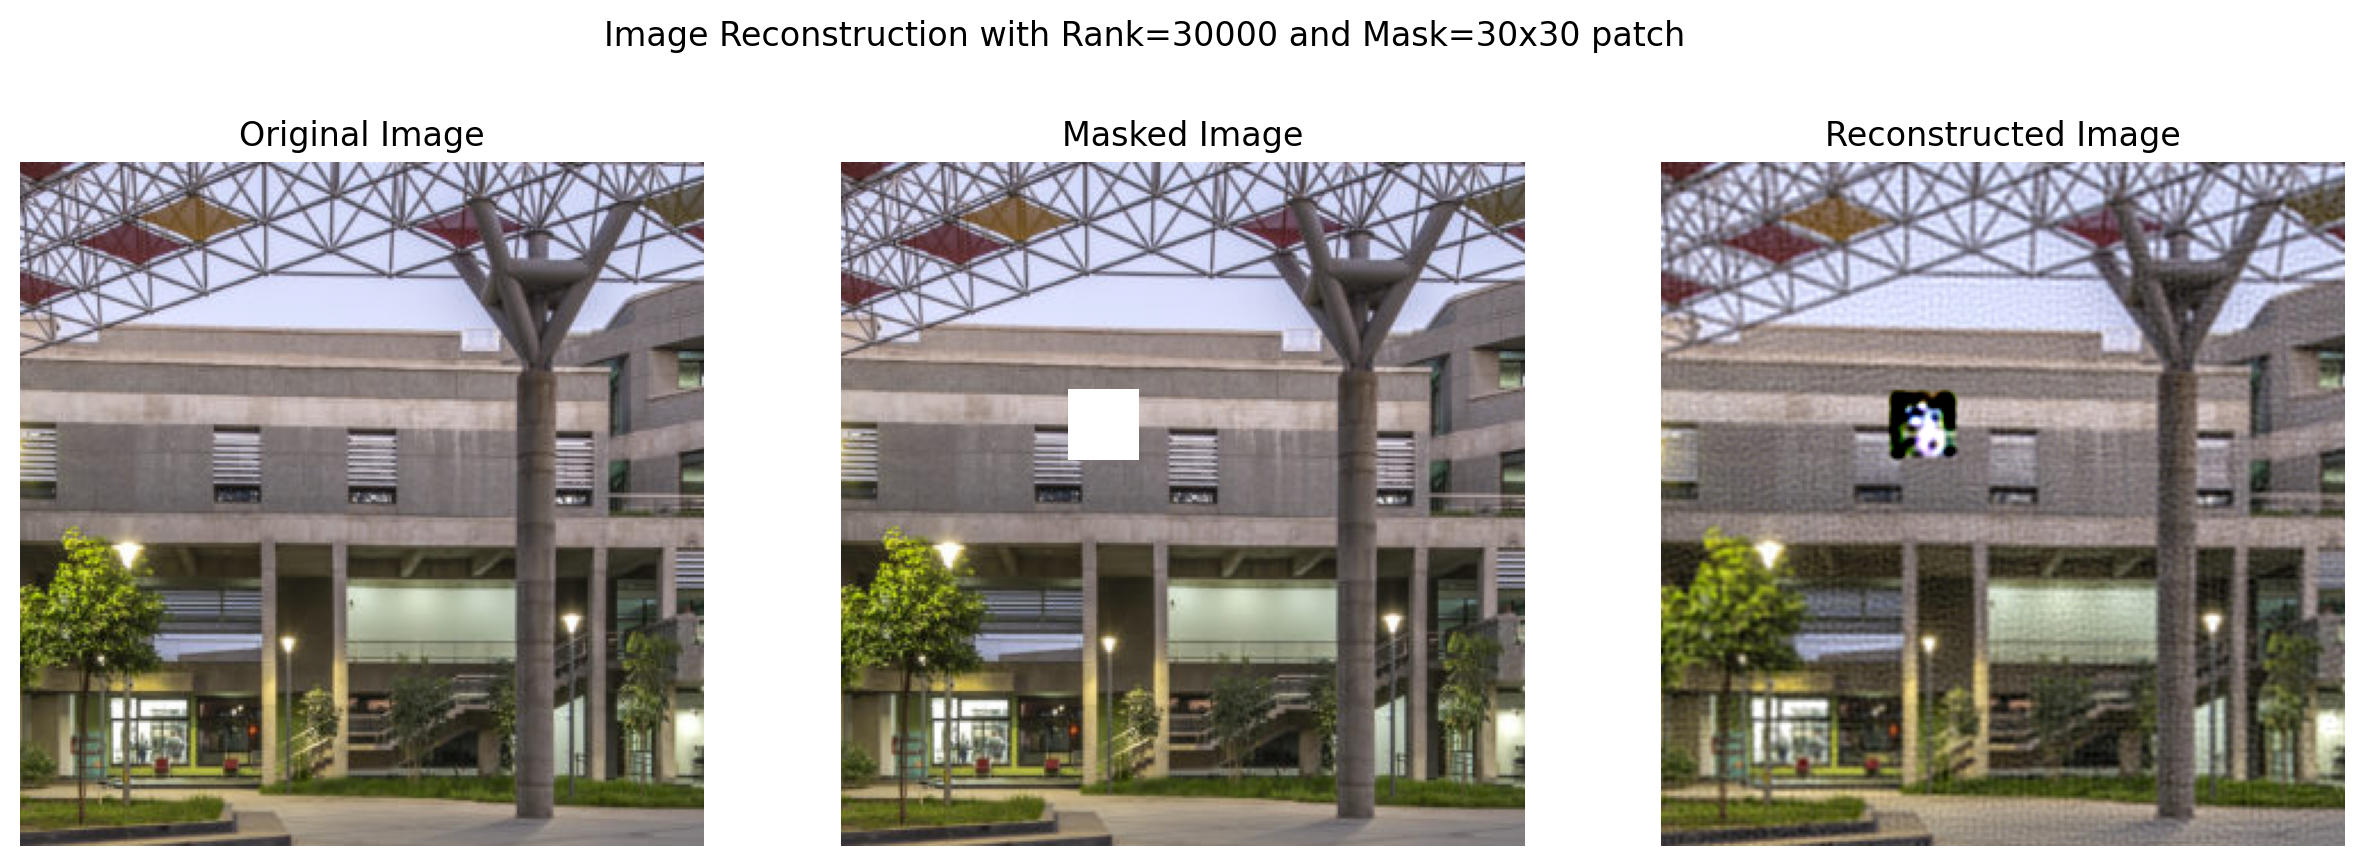

RMSE: 0.06989781215627563
PSNR: 23.110728354421717


In [37]:
plot_results(crop, masked_img, X_pred, rank=30000, mask_value=30)
rmse, psnr = calculate_rmse_psnr(crop, X_pred)

In [38]:
del X, Y, X_scaled, X_transformed, X_pred

In [39]:
del X_rff, rff, net

## Using 40k features

### Create 40k RFF Features

In [40]:
X_rff, rff = create_rff_features(img_X_scaled, num_features=40000, sigma=0.008)
X_rff.shape

torch.Size([89100, 40000])

### Train a Linear Model

In [41]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, lr=0.005, X=X_rff, Y=img_Y, epochs=2000)

# save the model
torch.save(net, "linear_model_epoch2000_features40k.pth")

Epoch 100 loss: 0.021429
Epoch 200 loss: 0.008095
Epoch 300 loss: 0.005137
Epoch 400 loss: 0.003692
Epoch 500 loss: 0.002958
Epoch 600 loss: 0.002591
Epoch 700 loss: 0.002413
Epoch 800 loss: 0.002328
Epoch 900 loss: 0.002288
Epoch 1000 loss: 0.002268
Epoch 1100 loss: 0.002257
Epoch 1200 loss: 0.002250
Epoch 1300 loss: 0.002245
Epoch 1400 loss: 0.002241
Epoch 1500 loss: 0.002237
Epoch 1600 loss: 0.002234
Epoch 1700 loss: 0.002232
Epoch 1800 loss: 0.002229
Epoch 1900 loss: 0.002227
Epoch 2000 loss: 0.002225


In [42]:
# # load the model
# net = torch.load("linear_model_epoch2000_features40k.pth")
# net.to(device)

In [43]:
# cuda clear cache
torch.cuda.empty_cache()

import gc
gc.collect()

7814

### Predict the reconstructed image

In [44]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler_X.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)
X_pred = rearrange(X_pred, '(h w) c -> c h w', h = 300, w = 300)
X_pred = torch.clamp(X_pred, 0, 1)


### Plot the reconstructed image and calculate RMSE and PSNR

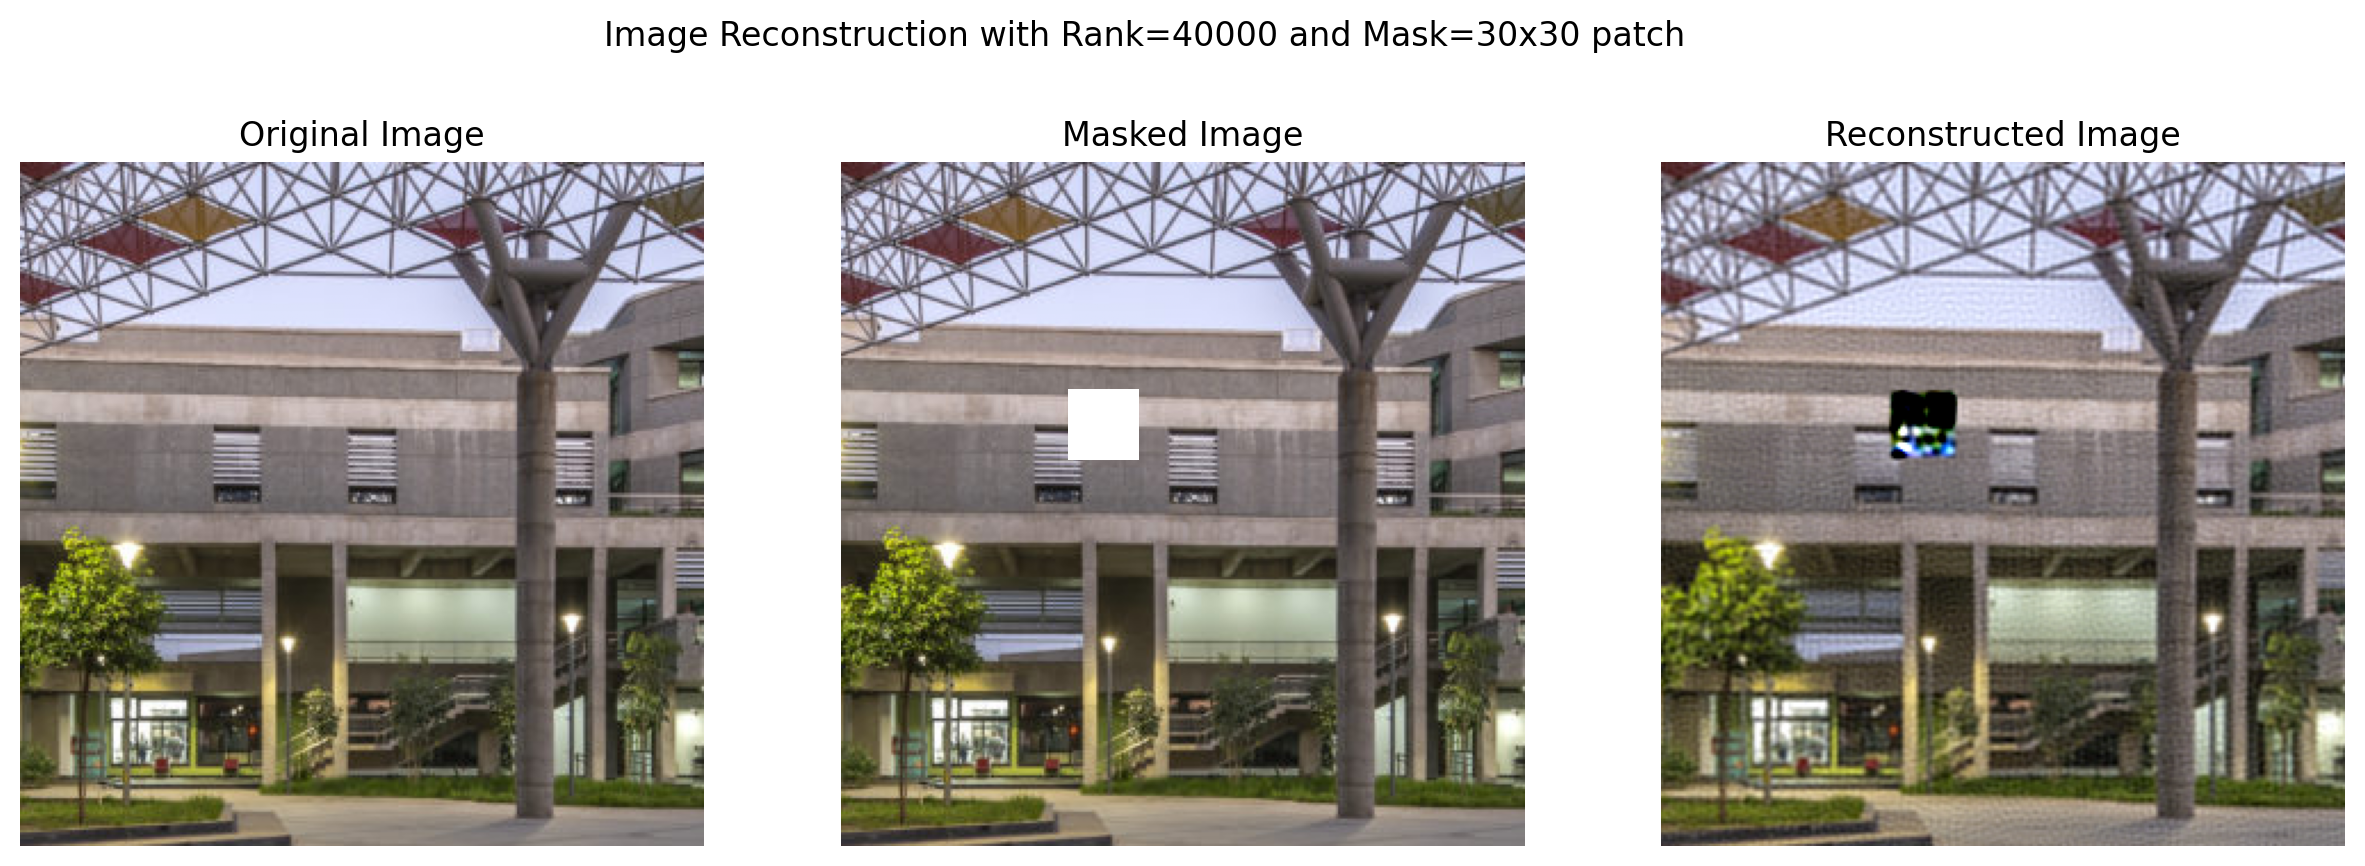

RMSE: 0.07063123195334976
PSNR: 23.02006437394997


In [45]:
plot_results(crop, masked_img, X_pred, rank=40000, mask_value=30)
rmse, psnr = calculate_rmse_psnr(crop, X_pred)

In [46]:
del X, Y, X_scaled, X_transformed, X_pred

In [47]:
del X_rff, rff, net